## Cell type annotation by scArches label transfer
Train scArches VAE model sequentially on head and antenna reference datasets and predict cell types labels for w1118_42d and drprnull_42d samples

In [1]:
!python --version

Python 3.12.2


## Load required packages

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scvi
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import gdown
import copy as cp
import os
import plotnine as p
import pickle

sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


scanpy==1.10.0 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


## Check GPU availability and configuration

In [3]:
print(os.getenv("CUDA_VISIBLE_DEVICES"))
os.environ["CUDA_VISIBLE_DEVICES"]=os.getenv("CUDA_VISIBLE_DEVICES")

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

1
True
1
0
Tesla P100-PCIE-12GB


## Set up I/O and read reference and query datasets
Fly cell atlas head and antenna datasets will be used as references, obtained from https://flycellatlas.org/
10x raw H5AD files were downloaded for both head and antenna

In [4]:
## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
referencepath = basepath.joinpath('reference','FCA')
inputpath = basepath.joinpath('analysis','preprocess')
outputpath = basepath.joinpath('analysis','scarches')

In [5]:
## Read reference datasets
fca_reference_head = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_head_10x_raw.h5ad"))
fca_reference_antenna = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_antenna_10x_raw.h5ad"))

fca_reference_head.layers["counts"] = fca_reference_head.X.copy()
fca_reference_antenna.layers["counts"] = fca_reference_antenna.X.copy()

## combine tissue and batch info from each dataset to for unique categorical covariates 
fca_reference_head.obs['tissue'] = "fca_head"
fca_reference_head.obs['tissue_batch'] = fca_reference_head.obs['batch'].astype(str)+"_"+fca_reference_head.obs['tissue'].astype(str)
fca_reference_antenna.obs['tissue'] = "fca_antenna"
fca_reference_antenna.obs['tissue_batch'] = fca_reference_antenna.obs['batch'].astype(str)+"_"+fca_reference_antenna.obs['tissue'].astype(str)


print(fca_reference_head.shape,fca_reference_antenna.shape)

(100527, 13056) (37254, 13203)


In [6]:
## read query datasets
w1118_42d = sc.read_h5ad(inputpath.joinpath("w1118_42d_slim.h5ad"))
w1118_42d.raw = w1118_42d

drprnull_42d = sc.read_h5ad(inputpath.joinpath("drprnull_42d_slim.h5ad"))
drprnull_42d.raw = drprnull_42d

print(w1118_42d.shape,drprnull_42d.shape )

(9033, 16507) (6423, 16507)


In [7]:
## Subset reference datasets to have genes common to query datasets 

common_genes = list(set(w1118_42d.var_names) & set(drprnull_42d.var_names)  & set(fca_reference_head.var_names) & set(fca_reference_antenna.var_names) )
print(len(common_genes))

fca_reference_head = fca_reference_head[:,common_genes ]
fca_reference_head = fca_reference_head.copy()

fca_reference_antenna = fca_reference_antenna[:,common_genes ]
fca_reference_antenna = fca_reference_antenna.copy()

w1118_42d = w1118_42d[:,common_genes]
w1118_42d = w1118_42d.copy()

drprnull_42d = drprnull_42d[:,common_genes]
drprnull_42d = drprnull_42d.copy()

print(fca_reference_antenna.shape,fca_reference_head.shape,w1118_42d.shape,drprnull_42d.shape)

12008
(37254, 12008) (100527, 12008) (9033, 12008) (6423, 12008)


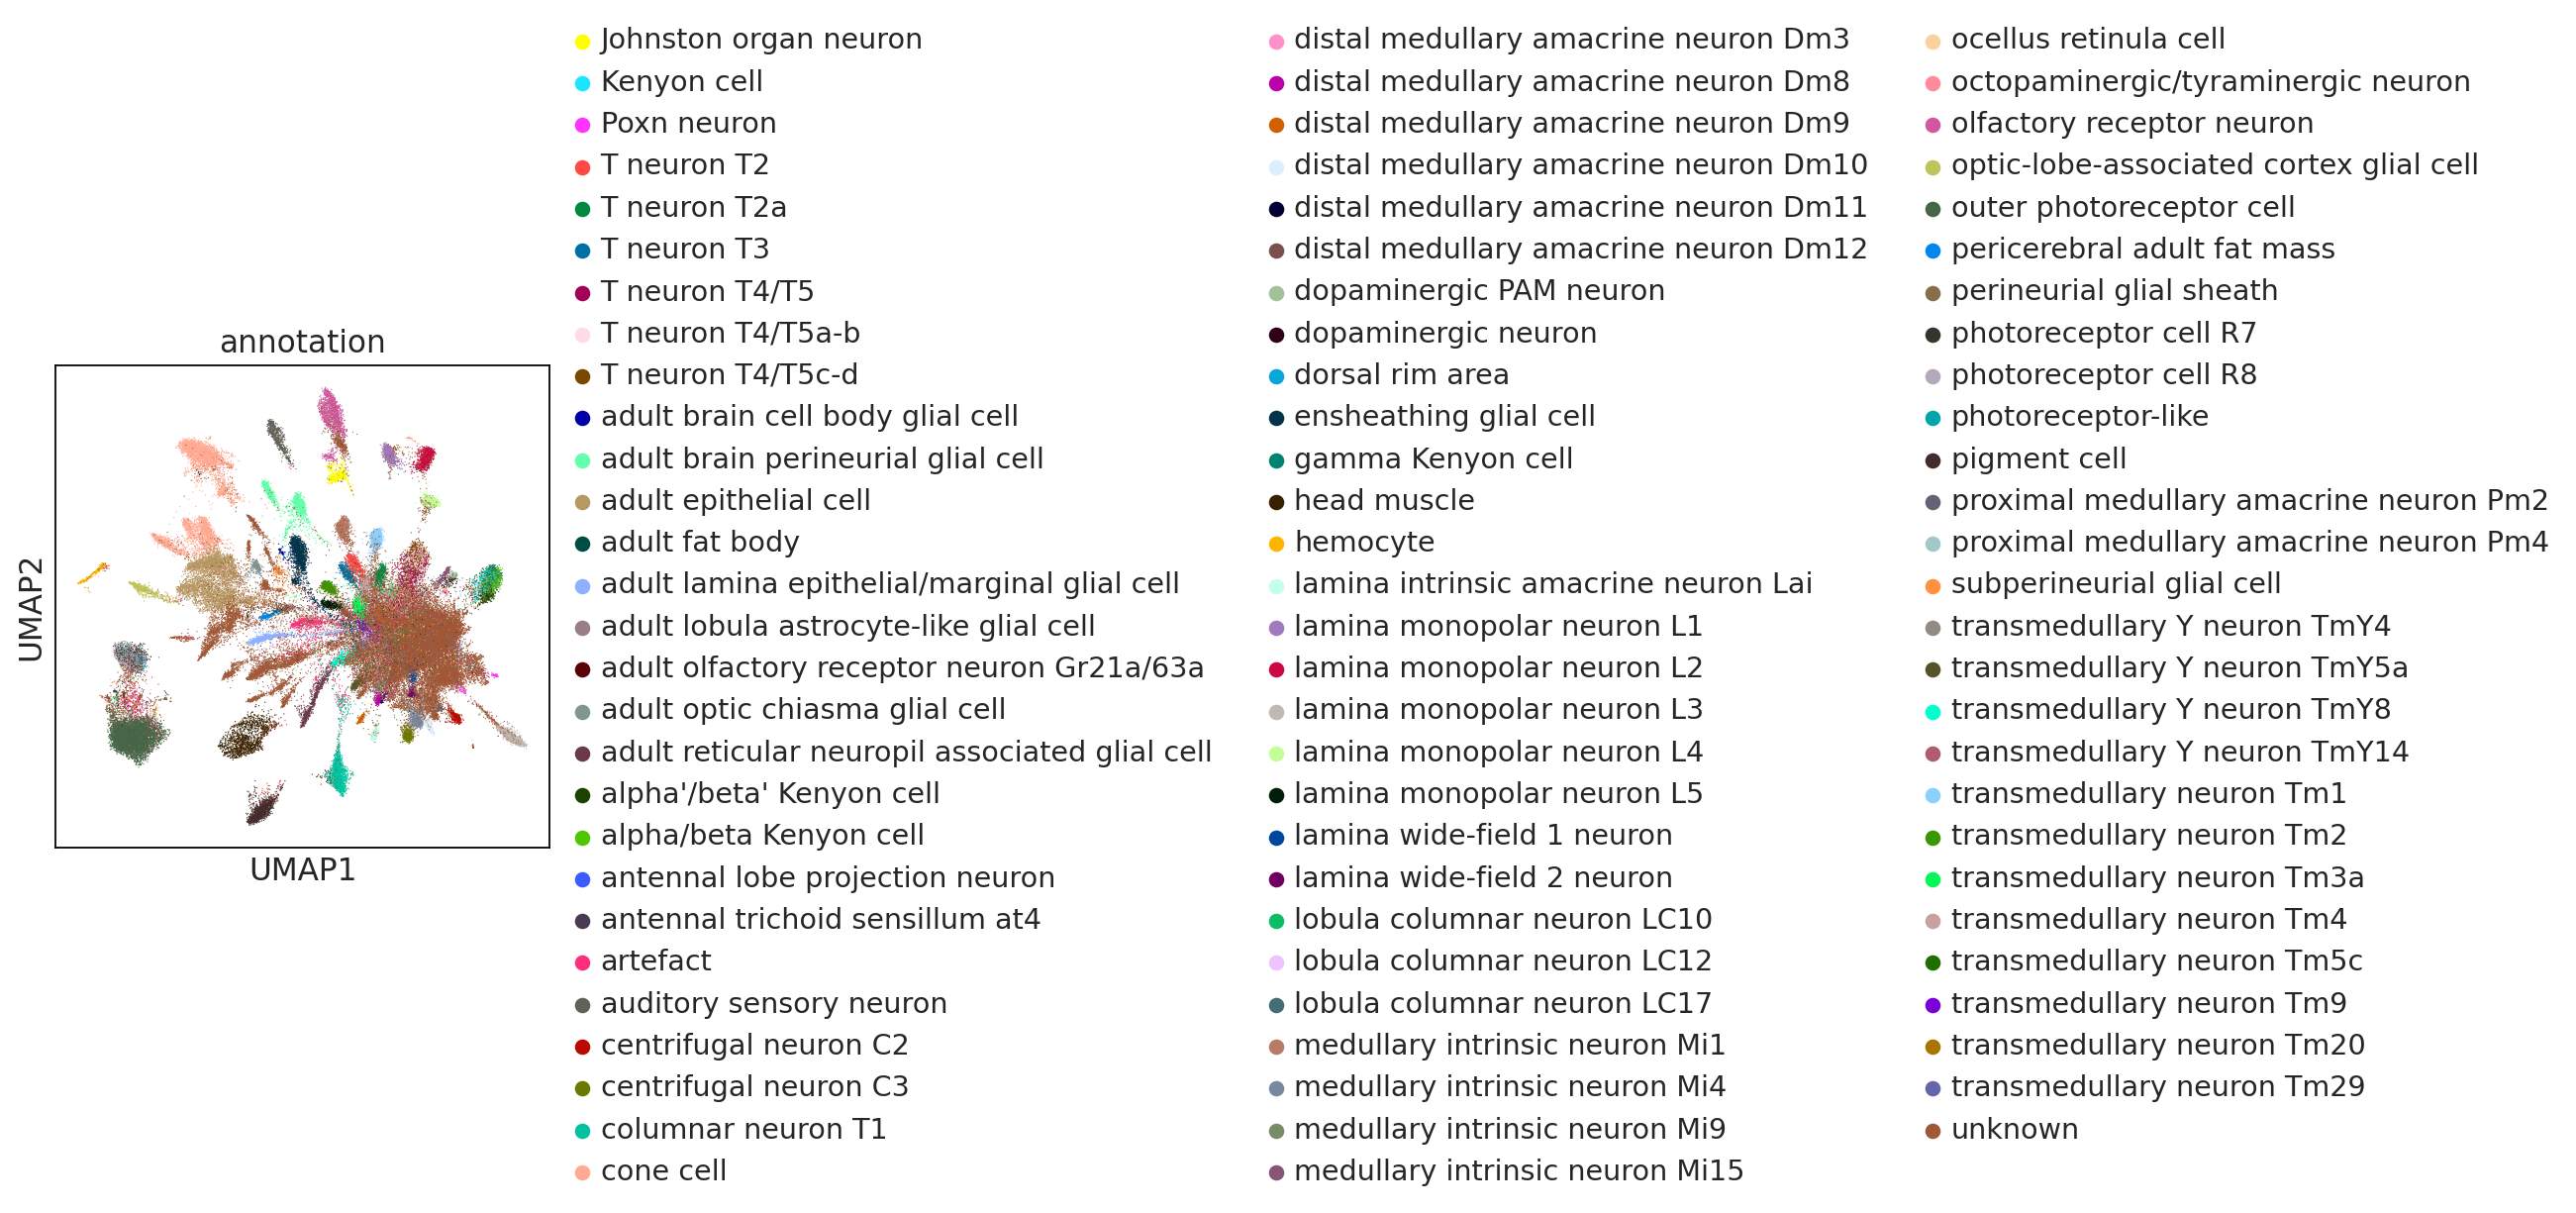

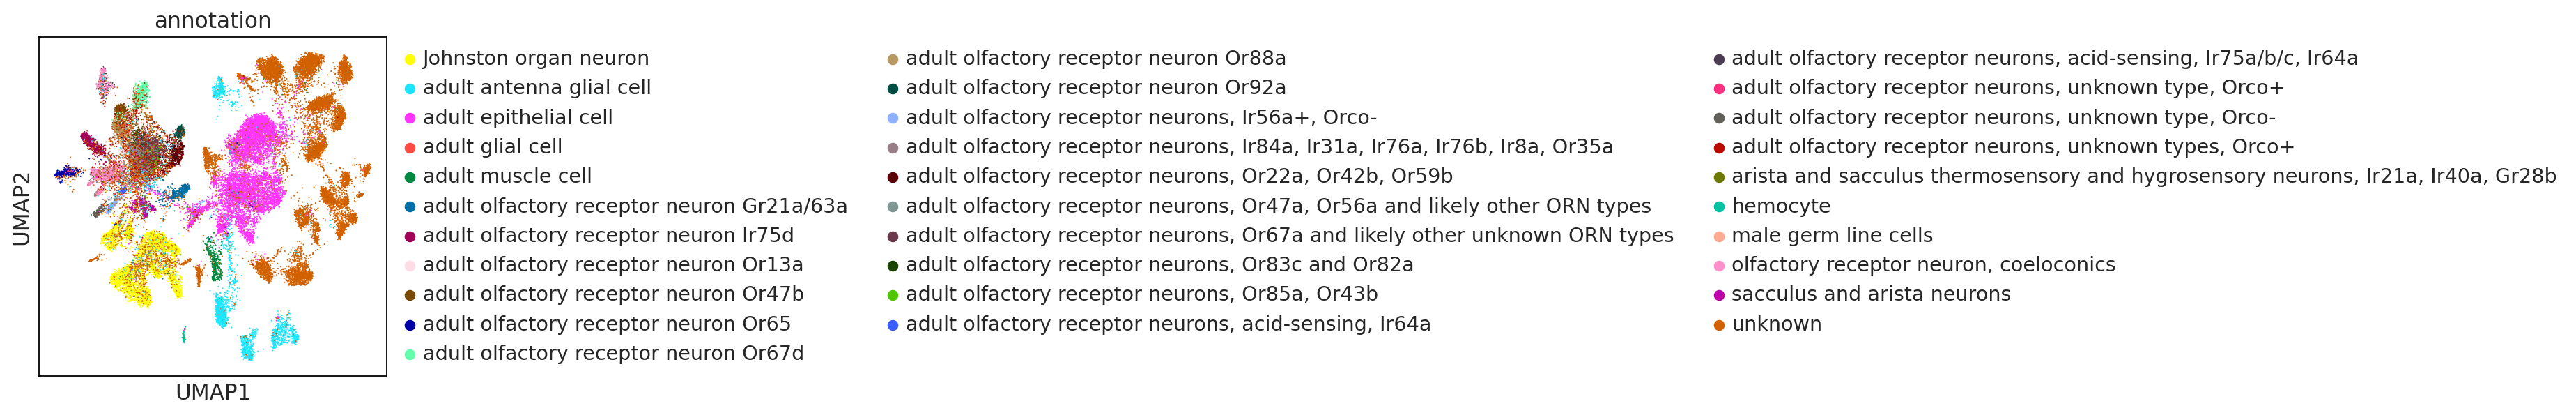

In [8]:
sc.pl.umap(fca_reference_head,color="annotation")
sc.pl.umap(fca_reference_antenna,color="annotation")

## Train model on head reference 

In [9]:
sc.pp.normalize_total(fca_reference_head)
sc.pp.log1p(fca_reference_head)
fca_reference_head.raw = fca_reference_head

sc.pp.highly_variable_genes(
    fca_reference_head,
    n_top_genes=2000,
    batch_key="tissue_batch",
    subset=True)

## sca.models.SCVI.setup_anndata(fca_reference_head, batch_key="tissue_batch",categorical_covariate_keys=["age","fly_genetics","tissue","dissection_lab","sex"])
sca.models.SCVI.setup_anndata(fca_reference_head, batch_key="tissue_batch") ## NotImplementedError: scArches currently does not support models with extra categorical covariates.
head_vae = sca.models.SCVI(
    fca_reference_head,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none"
)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:23)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?


In [10]:
head_vae.train(max_epochs=200, check_val_every_n_epoch = 1)
head_latent = sc.AnnData(head_vae.get_latent_representation())
head_latent.obs["batch"] = fca_reference_head.obs["batch"].tolist()
head_latent.obs["tissue"] = fca_reference_head.obs["tissue"].tolist()
head_latent.obs["tissue_batch"] = fca_reference_head.obs["tissue_batch"].tolist()
head_latent.obs["annotation"] = fca_reference_head.obs["annotation"].tolist()
head_latent.obs["broad_annotation"] = fca_reference_head.obs["broad_annotation"].tolist()
head_latent.obs["broad_annotation_extrapolated"] = fca_reference_head.obs["broad_annotation_extrapolated"].tolist()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 2/200:   0%|          | 1/200 [00:09<30:22,  9.16s/it, v_num=1, train_loss_step=243, train_loss_epoch=252]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 3/200:   1%|          | 2/200 [00:17<29:24,  8.91s/it, v_num=1, train_loss_step=233, train_loss_epoch=233]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 4/200:   2%|▏         | 3/200 [00:26<29:02,  8.85s/it, v_num=1, train_loss_step=228, train_loss_epoch=226]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 5/200:   2%|▏         | 4/200 [00:35<28:45,  8.80s/it, v_num=1, train_loss_step=222, train_loss_epoch=223]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 6/200:   2%|▎         | 5/200 [00:44<28:35,  8.80s/it, v_num=1, train_loss_step=220, train_loss_epoch=221]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 7/200:   3%|▎         | 6/200 [00:52<28:25,  8.79s/it, v_num=1, train_loss_step=222, train_loss_epoch=219]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 8/200:   4%|▎         | 7/200 [01:01<28:14,  8.78s/it, v_num=1, train_loss_step=219, train_loss_epoch=218]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 9/200:   4%|▍         | 8/200 [01:10<28:09,  8.80s/it, v_num=1, train_loss_step=218, train_loss_epoch=217]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 10/200:   4%|▍         | 9/200 [01:19<28:07,  8.84s/it, v_num=1, train_loss_step=214, train_loss_epoch=217]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 11/200:   5%|▌         | 10/200 [01:28<28:00,  8.85s/it, v_num=1, train_loss_step=220, train_loss_epoch=216]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 12/200:   6%|▌         | 11/200 [01:37<27:50,  8.84s/it, v_num=1, train_loss_step=212, train_loss_epoch=216]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 13/200:   6%|▌         | 12/200 [01:45<27:39,  8.83s/it, v_num=1, train_loss_step=217, train_loss_epoch=216]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 14/200:   6%|▋         | 13/200 [01:54<27:33,  8.84s/it, v_num=1, train_loss_step=212, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 15/200:   7%|▋         | 14/200 [02:03<27:21,  8.83s/it, v_num=1, train_loss_step=214, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 16/200:   8%|▊         | 15/200 [02:12<27:10,  8.81s/it, v_num=1, train_loss_step=215, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 17/200:   8%|▊         | 16/200 [02:21<27:00,  8.81s/it, v_num=1, train_loss_step=211, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 18/200:   8%|▊         | 17/200 [02:30<26:50,  8.80s/it, v_num=1, train_loss_step=215, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 19/200:   9%|▉         | 18/200 [02:38<26:39,  8.79s/it, v_num=1, train_loss_step=216, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 20/200:  10%|▉         | 19/200 [02:47<26:29,  8.78s/it, v_num=1, train_loss_step=210, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 21/200:  10%|█         | 20/200 [02:56<26:20,  8.78s/it, v_num=1, train_loss_step=217, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 22/200:  10%|█         | 21/200 [03:05<26:11,  8.78s/it, v_num=1, train_loss_step=214, train_loss_epoch=215]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 23/200:  11%|█         | 22/200 [03:13<26:03,  8.78s/it, v_num=1, train_loss_step=209, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 24/200:  12%|█▏        | 23/200 [03:22<25:53,  8.78s/it, v_num=1, train_loss_step=217, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 25/200:  12%|█▏        | 24/200 [03:31<25:44,  8.77s/it, v_num=1, train_loss_step=219, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 26/200:  12%|█▎        | 25/200 [03:40<25:34,  8.77s/it, v_num=1, train_loss_step=219, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 27/200:  13%|█▎        | 26/200 [03:48<25:26,  8.77s/it, v_num=1, train_loss_step=218, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 28/200:  14%|█▎        | 27/200 [03:57<25:16,  8.77s/it, v_num=1, train_loss_step=217, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 29/200:  14%|█▍        | 28/200 [04:06<25:10,  8.78s/it, v_num=1, train_loss_step=213, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 30/200:  14%|█▍        | 29/200 [04:15<25:03,  8.79s/it, v_num=1, train_loss_step=215, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 31/200:  15%|█▌        | 30/200 [04:24<24:54,  8.79s/it, v_num=1, train_loss_step=217, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 32/200:  16%|█▌        | 31/200 [04:32<24:43,  8.78s/it, v_num=1, train_loss_step=213, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 33/200:  16%|█▌        | 32/200 [04:41<24:34,  8.78s/it, v_num=1, train_loss_step=214, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 34/200:  16%|█▋        | 33/200 [04:50<24:23,  8.76s/it, v_num=1, train_loss_step=215, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 35/200:  17%|█▋        | 34/200 [04:59<24:12,  8.75s/it, v_num=1, train_loss_step=211, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 36/200:  18%|█▊        | 35/200 [05:07<24:05,  8.76s/it, v_num=1, train_loss_step=217, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 37/200:  18%|█▊        | 36/200 [05:16<23:55,  8.75s/it, v_num=1, train_loss_step=217, train_loss_epoch=214]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


In [ ]:
print(head_vae)
sc.pp.neighbors(head_latent, n_neighbors=8)
sc.tl.leiden(head_latent)
sc.tl.umap(head_latent)

In [ ]:
history_df = (
    head_vae.history['elbo_train'].astype(float)
    .join(head_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head VAE model")
    + p.theme_minimal()
)


print(p_)

## Save the trained head model

In [ ]:
head_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_model/"
head_vae.save(head_model, overwrite=True)
head_latent.write(head_model+'reference_latent.h5ad')

## Construct tree hierarchy for head model

In [ ]:
head_latent.obs['broad_annotation_tissue'] = np.char.add(np.char.add(np.array(head_latent.obs['broad_annotation'], dtype= str), '-'),
                                             np.array(head_latent.obs['tissue'], dtype=str))
head_latent.obs['annotation_tissue'] = np.char.add(np.char.add(np.array(head_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(head_latent.obs['tissue'], dtype=str))

head_latent.obs['broad_annotation_tissue_batch'] = np.char.add(np.char.add(np.array(head_latent.obs['broad_annotation'], dtype= str), '-'),
                                             np.array(head_latent.obs['tissue_batch'], dtype=str))
head_latent.obs['annotation_tissue_batch'] = np.char.add(np.char.add(np.array(head_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(head_latent.obs['tissue_batch'], dtype=str))

In [ ]:
tissueorder = head_latent.obs.tissue.unique().tolist()
tree_head_broadannotation_tissue, mp_head_broadannotation_tissue = sca.classifiers.scHPL.learn_tree(data = head_latent,
                batch_key = 'tissue',
                batch_order = tissueorder ,
                cell_type_key='broad_annotation_tissue',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
tree_head_fullannotation_tissue, mp_head_fullannotation_tissue = sca.classifiers.scHPL.learn_tree(data = head_latent,
                batch_key = 'tissue',
                batch_order = tissueorder ,
                cell_type_key='annotation_tissue',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
tissue_batchorder = head_latent.obs.tissue_batch.unique().tolist()
tree_head_broadannotation_tissue_batch, mp_head_broadannotation_tissue_batch = sca.classifiers.scHPL.learn_tree(data = head_latent,
                batch_key = 'tissue_batch',
                batch_order = tissue_batchorder ,
                cell_type_key='broad_annotation_tissue_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
tree_head_fullannotation_tissue_batch, mp_head_fullannotation_tissue_batch = sca.classifiers.scHPL.learn_tree(data = head_latent,
                batch_key = 'tissue_batch',
                batch_order = tissue_batchorder ,
                cell_type_key='annotation_tissue_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
## Write tree hierarchy as pickle file
## Tissue only 
with open(head_model+'tree_head_broadannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(tree_head_broadannotation_tissue, f)
f.close()

with open(head_model+'mp_head_broadannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(mp_head_broadannotation_tissue, f) 
f.close()


with open(head_model+'tree_head_fullannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(tree_head_fullannotation_tissue, f)
f.close()

with open(head_model+'mp_head_fullannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(mp_head_fullannotation_tissue, f) 
f.close()

## Tissue & batch 
with open(head_model+'tree_head_broadannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(tree_head_broadannotation_tissue_batch, f)
f.close()

with open(head_model+'mp_head_broadannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(mp_head_broadannotation_tissue_batch, f) 
f.close()


with open(head_model+'tree_head_fullannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(tree_head_fullannotation_tissue_batch, f)
f.close()

with open(head_model+'mp_head_fullannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(mp_head_fullannotation_tissue_batch, f) 
f.close()

## Integrate the antenna reference with the pretrained head model

In [ ]:
fca_reference_antenna = fca_reference_antenna[:,fca_reference_head.var_names]
fca_reference_antenna

In [ ]:
fca_reference_antenna = fca_reference_antenna.copy()
head_antenna_vae = sca.models.SCVI.load_query_data(
    fca_reference_antenna,
    head_model,
    freeze_dropout = True,
)

In [ ]:
head_antenna_vae.train(max_epochs=200, check_val_every_n_epoch = 1)

In [ ]:
history_df = (
    head_antenna_vae.history['elbo_train'].astype(float)
    .join(head_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("head, antenna combined VAE model")
    + p.theme_minimal()
)


print(p_)

In [ ]:
head_antenna_latent = sc.AnnData(head_antenna_vae.get_latent_representation())
head_antenna_latent.obs["batch"] = fca_reference_antenna.obs["batch"].tolist()
head_antenna_latent.obs["tissue"] = fca_reference_antenna.obs["tissue"].tolist()
head_antenna_latent.obs["tissue_batch"] = fca_reference_antenna.obs["tissue_batch"].tolist()
head_antenna_latent.obs["annotation"] = fca_reference_antenna.obs["annotation"].tolist()
head_antenna_latent.obs["broad_annotation"] = fca_reference_antenna.obs["broad_annotation"].tolist()
head_antenna_latent.obs["broad_annotation_extrapolated"] = fca_reference_antenna.obs["broad_annotation_extrapolated"].tolist()


In [ ]:
head_antenna_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_antenna_model/"
head_antenna_vae.save(head_antenna_model, overwrite=True)
head_antenna_latent.write(head_antenna_model+'reference_latent.h5ad')

In [ ]:
fca_reference_combined = fca_reference_head.concatenate(fca_reference_antenna, batch_key="head_antenna")
fca_reference_combined

In [ ]:
combined_latent = sc.AnnData(head_antenna_vae.get_latent_representation(adata=fca_reference_combined))
combined_latent.obs["tissue"] = fca_reference_combined.obs["tissue"].tolist()
combined_latent.obs["batch"] = fca_reference_combined.obs["batch"].tolist()
combined_latent.obs["tissue_batch"] = fca_reference_combined.obs["tissue_batch"].tolist()
combined_latent.obs["annotation"] = fca_reference_combined.obs["annotation"].tolist()
combined_latent.obs["broad_annotation"] = fca_reference_combined.obs["broad_annotation"].tolist()
combined_latent.obs["broad_annotation_extrapolated"] = fca_reference_combined.obs["broad_annotation_extrapolated"].tolist()

combined_latent

In [ ]:
combined_latent.obs

In [ ]:
sc.pp.neighbors(combined_latent)
sc.tl.leiden(combined_latent)
sc.tl.umap(combined_latent)

In [ ]:
sc.pl.umap(combined_latent,
           color=['tissue','tissue_batch'],
           frameon=False,
           wspace=0.6, s=25,
           #palette=sns.color_palette('colorblind', as_cmap=True)[:5],
           #save='study_query.pdf'
           )

In [ ]:
sc.pl.umap(combined_latent,
           color=['broad_annotation'],
           frameon=False,
           wspace=0.6, s=25,
           #palette=sns.color_palette('colorblind', as_cmap=True)[:5],
           #save='study_query.pdf'
           )

In [ ]:
for s in np.unique(combined_latent.obs.tissue):
    ref_s = cp.deepcopy(combined_latent)
    ref_s.obs.broad_annotation[combined_latent.obs.tissue != s] = np.nan

    sc.pl.umap(ref_s,
               color=['broad_annotation'],
               frameon=False,
               wspace=0.6, s=60,
               #palette=sns.color_palette('colorblind', as_cmap=True), title=s,
               #save=s+'_query.pdf'
               )

## Update tree hierarchy with antenna labels

In [ ]:
combined_latent.obs['broad_annotation_tissue'] = np.char.add(np.char.add(np.array(combined_latent.obs['broad_annotation'], dtype= str), '-'),
                                             np.array(combined_latent.obs['tissue'], dtype=str))
combined_latent.obs['annotation_tissue'] = np.char.add(np.char.add(np.array(combined_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(combined_latent.obs['tissue'], dtype=str))

combined_latent.obs['broad_annotation_tissue_batch'] = np.char.add(np.char.add(np.array(combined_latent.obs['broad_annotation'], dtype= str), '-'),
                                             np.array(combined_latent.obs['tissue_batch'], dtype=str))
combined_latent.obs['annotation_tissue_batch'] = np.char.add(np.char.add(np.array(combined_latent.obs['annotation'], dtype= str), '-'),
                                             np.array(combined_latent.obs['tissue_batch'], dtype=str))

In [ ]:
tissueorder = combined_latent.obs.tissue.unique().tolist()
tree_combined_broadannotation_tissue, mp_combined_broadannotation_tissue = sca.classifiers.scHPL.learn_tree(data = combined_latent,
                batch_key = 'tissue',
                batch_order = tissueorder ,
                cell_type_key='broad_annotation_tissue',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
tree_combined_fullannotation_tissue, mp_combined_fullannotation_tissue = sca.classifiers.scHPL.learn_tree(data = combined_latent,
                batch_key = 'tissue',
                batch_order = tissueorder ,
                cell_type_key='annotation_tissue',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
tissue_batchorder = combined_latent.obs.tissue.unique().tolist()
tree_combined_broadannotation_tissue_batch, mp_combined_broadannotation_tissue_batch = sca.classifiers.scHPL.learn_tree(data = combined_latent,
                batch_key = 'tissue_batch',
                batch_order = tissue_batchorder ,
                cell_type_key='broad_annotation_tissue_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
tree_combined_fullannotation_tissue_batch, mp_combined_fullannotation_tissue_batch = sca.classifiers.scHPL.learn_tree(data = combined_latent,
                batch_key = 'tissue_batch',
                batch_order = tissue_batchorder ,
                cell_type_key='annotation_tissue_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)

In [ ]:
## Write tree hierarchy as pickle file
## Tissue only
with open(head_antenna_model+'tree_combined_broadannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(tree_combined_broadannotation_tissue, f)
f.close()

with open(head_antenna_model+'mp_combined_broadannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(mp_combined_broadannotation_tissue, f) 
f.close()

with open(head_antenna_model+'tree_combined_fullannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(tree_combined_fullannotation_tissue, f)
f.close()

with open(head_antenna_model+'mp_combined_fullannotation_tissue.pkl', 'wb') as f: 
    pickle.dump(mp_combined_fullannotation_tissue, f) 
f.close()

## Tissue & batch combined 

with open(head_antenna_model+'tree_combined_broadannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(tree_combined_broadannotation_tissue_batch, f)
f.close()

with open(head_antenna_model+'mp_combined_broadannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(mp_combined_broadannotation_tissue_batch, f) 
f.close()

with open(head_antenna_model+'tree_combined_fullannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(tree_combined_fullannotation_tissue_batch, f)
f.close()

with open(head_antenna_model+'mp_combined_fullannotation_tissue_batch.pkl', 'wb') as f: 
    pickle.dump(mp_combined_fullannotation_tissue_batch, f) 
f.close()